In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt

# import data

In [2]:
df=pd.read_excel(r'C:\Users\User\Downloads\v8-2.xlsx')

# preproccessing

In [3]:
df = df[df['P/S(gf/cm)'].isnull() == 0]
df = df[df['desmear time'].isnull() == 0]
df = df.reset_index(drop=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 7 columns):
surface              169 non-null object
type by SEM          143 non-null object
type by Alfa-step    143 non-null object
desmear time         169 non-null object
Rq(um)               130 non-null float64
P/S(gf/cm)           169 non-null float64
version              169 non-null int64
dtypes: float64(2), int64(1), object(4)
memory usage: 9.3+ KB


In [5]:
df['type by SEM'] = df['type by SEM'].fillna(mode(df['type by SEM'])[0][0])
df['type by Alfa-step'] = df['type by Alfa-step'].fillna(df['type by SEM'])
df['Rq(um)'] = df['Rq(um)'].fillna(df['Rq(um)'].mean())
df['desmear time'] = df['desmear time'].str[0:-3].astype('float')

In [6]:
df['surface']=df['surface'].map({'A':0,'B':1})
df['type by SEM']=df['type by SEM'].map({'A':1,'B':2,'C':3,'D':4})
df['type by Alfa-step']=df['type by Alfa-step'].map({'A':1,'B':2,'C':3,'D':4})

In [7]:
data_y = df['P/S(gf/cm)']
data_x = df.drop(columns='P/S(gf/cm)')

# model fitting

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [9]:
model_jmda = RandomForestRegressor()
para = {'n_estimators':range(1,30),'max_depth':range(1,20)}
grid = GridSearchCV(model_jmda,para,cv=3,scoring='neg_mean_squared_error')

In [10]:
grid.fit(data_x,data_y)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(1, 20),
    

In [11]:
grid.best_params_,grid.best_score_

({'max_depth': 3, 'n_estimators': 6}, -24814.32933564111)

In [12]:
cv_detail = pd.DataFrame(grid.cv_results_)[['param_max_depth','param_n_estimators','mean_test_score']]
cv_detail.sort_values('mean_test_score',ascending=False).head(5)

,param_max_depth,param_n_estimators,mean_test_score
63,3,6,-24814.329336
62,3,5,-24879.349787
58,3,1,-25486.640835
73,3,16,-25648.286202
79,3,22,-26089.382846


In [13]:
model_jmda = RandomForestRegressor(max_depth=3,n_estimators=20)

In [14]:
model_jmda.fit(data_x,data_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

# partial plot method

In [20]:
from pdpbox import pdp
from sklearn.mixture import GaussianMixture

Text(0.5, 0, 'type by SEM')

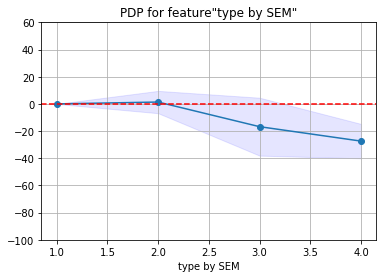

In [24]:
column = 'type by SEM'

#1.predict y with different x values
data_1 = data_x.copy()
data_1[column] = 1
y1 = model_jmda.predict(data_1)
data_2 = data_x.copy()
data_2[column] = 2
y2 = model_jmda.predict(data_2)
data_3 = data_x.copy()
data_3[column] = 3
y3 = model_jmda.predict(data_3)
data_4 = data_x.copy()
data_4[column] = 4
y4 = model_jmda.predict(data_4)

#2.normalize
y1_n = ((y1/y1)-1)*data_y.mean()
y2_n = ((y2/y1)-1)*data_y.mean()
y3_n = ((y3/y1)-1)*data_y.mean()
y4_n = ((y4/y1)-1)*data_y.mean()

#3.Gauss distribution fitting
G1 = GaussianMixture().fit(y1_n.reshape(-1,1))
G2 = GaussianMixture().fit(y2_n.reshape(-1,1))
G3 = GaussianMixture().fit(y3_n.reshape(-1,1))
G4 = GaussianMixture().fit(y4_n.reshape(-1,1))

#5%(-1std),50%,95%(+1std)
Y_mid = np.array([G1.means_[0][0],G2.means_[0][0],G3.means_[0][0],G4.means_[0][0]])
Y_std = np.array([np.sqrt(G1.covariances_[0][0][0]),np.sqrt(G2.covariances_[0][0][0]),np.sqrt(G3.covariances_[0][0][0]),np.sqrt(G4.covariances_[0][0][0])])

#4.plot
plt.plot([1,2,3,4],Y_mid,'o-')
plt.fill_between([1,2,3,4],Y_mid+Y_std,Y_mid-Y_std,alpha=0.1,color='blue')
plt.axhline(color='red',ls='--')
plt.grid()
plt.title('PDP for feature"type by SEM"')
plt.ylim(-100,60)
plt.xlabel('type by SEM')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x17bf5413550>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x17bf54bf828>})

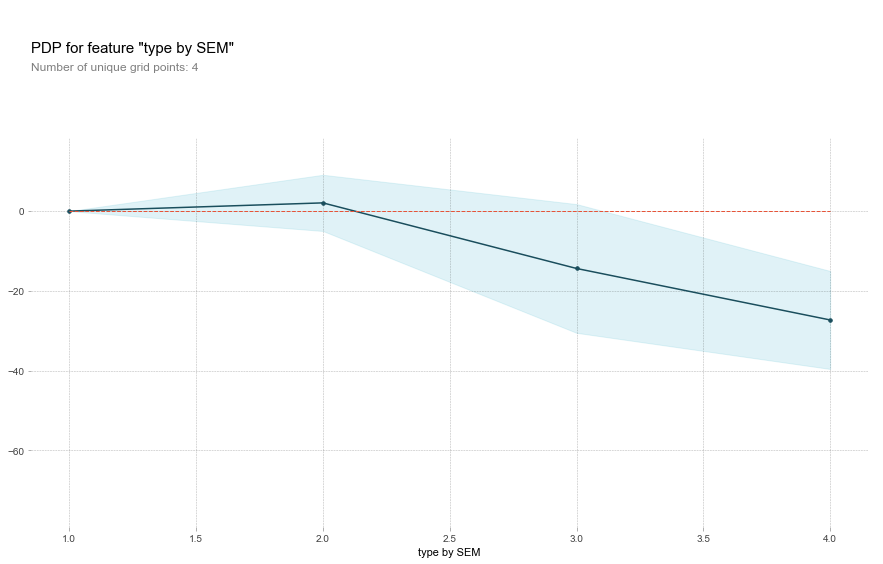

In [25]:
pdp_iso = pdp.pdp_isolate(model_jmda,data_x,model_features=list(data_x.columns),feature='type by SEM',num_grid_points=10)
pdp.pdp_plot(pdp_iso,feature_name='type by SEM')